In [125]:
%pip install qiskit

  Using cached scipy-1.7.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (28.5 MB)
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
ERROR: thewalrus 0.15.1 has requirement sympy>=1.5.1, but you'll have sympy 1.4 which is incompatible.
ERROR: strawberryfields 0.18.0 has requirement sympy>=1.5, but you'll have sympy 1.4 which is incompatible.
ERROR: strangeworks 2.4.5 has requirement antlr4-python3-runtime==4.8, but you'll have antlr4-python3-runtime 4.7.2 which is incompatible.
ERROR: strangeworks 2.4.5 has requirement pylatexenc==2.7, but you'll have pylatexenc 1.5 which is incompatible.
ERROR: pytket 0.12.0 has requirement networkx~=2.4, but you'll have networkx 2.2 which is incompatible.
ERROR: pytket 0.12.0 has requirement numpy~=1.20, but you'll have numpy 1.18.4 which is incompatible.
ERROR: pytket 0.12.0 has requirement sympy~=1.6, but you'll have sympy 1.4 which is incompatible.
ERROR: pytket-honeywell 0.12.0 has requirement nest-asyncio>=1.2, but you'll have 

In [126]:
%pip install pylatexenc
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute, IBMQ, assemble, Aer, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import getpass

# Using Grover's Algorithm to find collisions in hash functions

Grover's algorithm is a quantum algorithm that can solve an unstructured search problem in significantly less time than traditional searching algorithms. It finds solutions in two steps: converting the problem into an oracle and marks the solutions by amplification. A oracle is a quantum circuit that represents the problem so the algorithm can perform calculations on it. Amplitude tells the probabily that a state happens. Grover's algorithm increases amplitudes of correct states and decreases amplitudes of incorrect ones - this is named amplification.

### Hash Function
A hash function returns a unique value to a given input. This practice is called *hashing*. The function is useful in multiple ways; the most common implementations are to simplify the input and verify for uniqueness. For instance, the *SHA-256* is a function that gives a unique value by hashing the content in the file. However, hash functions are not impervious; they might give the same hash value for different inputs - we call this case *collision*. Collisions are problematic since they are by definition inconsistent with the purpose of hashing, especially in the field of cryptography.

### Our goal
We want to demonstrate that Grover's algorithm can be used to find collisions for hash functions. We will use the algorithm to find all possible inputs for a given hash value. Collisions would occur if we could see multiple states with equal, nonzero probabilities on a histogram.

### Implementation

We will first devise the hash algorithm that we want to search on. In our case, we will make a oversimplified hash function that will have many collisions. The hash function will take every two qubits, XOR them, and XOR the result of that to one of the four qubits of the clause qubits. The resulting value is an imperfect hash function with a few collisions that we can find.

The function defined below takes in a quantum circuit, the input qubits, the clause qubits (used for computation), the output qubit (whether the input was a "match" to the hash value), and the hash value to compare the result to.

In order for this to actually negate the phase of the state we are looking for, we use phase kickback to invert the phases of the control qubits. This will be seen later in the actual implementation of Grover's Algorithm.

In [11]:
def hash_oracle(qc, qubits, clause_qubits, output, hash_value):
    
    # Prepares the circuit to "compare" the clause_qubits to the hash_value
    exp = 0
    while exp < len(clause_qubits):
        if not hash_value & (1 << exp) > 0:
            qc.x(clause_qubits[exp])
        exp += 1
    qc.barrier()
    
    # XORs every two qubits and XORs the result of that into one of the clause_qubits
    for i in range(0, len(qubits), 1):
        qc.cx(qubits[i], clause_qubits[i % len(clause_qubits)])
        qc.cx(qubits[(i + 1) % len(qubits)], clause_qubits[i % len(clause_qubits)])
    
    # Checks if all the clause_qubits are satisfied
    qc.mct(clause_qubits, output)
    
    # Repeat all the steps to ensure that clause_qubits are |0000>
    for i in range(0, len(qubits), 1):
        qc.cx(qubits[i], clause_qubits[i % len(clause_qubits)])
        qc.cx(qubits[(i + 1) % len(qubits)], clause_qubits[i % len(clause_qubits)])
    
    qc.barrier()
    exp = 0
    while exp < len(clause_qubits):
        if not hash_value & (1 << exp) > 0:
            qc.x(clause_qubits[exp])
        exp += 1

With the hash oracle, we will now create the diffuser for Grover's algorithm. The diffuser is a general gate that is the same for every Grover's algorithm implementation. It takes the negated state from the oracle and amplifies it so that the probability of measuring that state is higher than it was before. Below is the implementation:

In [7]:
def diffuser(n):
    qc = QuantumCircuit(n)
    
    for qubit in range(n):
        qc.h(qubit)

    for qubit in range(n):
        qc.x(qubit)

    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)

    for qubit in range(n):
        qc.x(qubit)
        
    for qubit in range(n):
        qc.h(qubit)

    d = qc.to_gate()
    d.name = "Diffuser"
    return d

In [8]:
n_qubits = 4
iterations = int(n_qubits ** (1/2))
hash_value = 10

var_qubits = QuantumRegister(n_qubits, name='v')
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(n_qubits, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize the output qubit to |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize the qubits to the state |s> (intially the equal superposition or |+> state)
qc.h(var_qubits)
qc.barrier()

# Repeat the process _iterations_ times
for iteration in range(iterations):
    # Apply our oracle
    hash_oracle(qc, var_qubits, clause_qubits, output_qubit, hash_value)
    qc.barrier()
    # Apply the diffuser
    qc.append(diffuser(n_qubits), list(range(n_qubits)))

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)


┌───┐               ░       ░                                                                                       ░       ░ ┌───────────┐ ░                                                                                       ░       ░ ┌───────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───────░───■──────────────────────────────────■─────────■──────────────────────────────────■───░───────░─┤0          ├─░───■──────────────────────────────────■─────────■──────────────────────────────────■───░───────░─┤0          ├┤M├─────────
                      ├───┤               ░       ░   │                                  │         │                                  │   ░       ░ │           │ ░   │                                  │         │                                  │   ░       ░ │           │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───────░───┼────■────■────────────────────────┼─────────┼────■────■────────────────────────┼───░───────░─┤1          ├─░───┼────■────■────────────────────────┼─────────┼────■────■────────────────────────┼───░───────░─┤1          ├─╫─┤M├──────
                      ├───┤               ░       ░   │    │    │                        │         │    │    │                        │   ░       ░ │  Diffuser │ ░   │    │    │                        │         │    │    │                        │   ░       ░ │  Diffuser │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───────░───┼────┼────┼────■────■──────────────┼─────────┼────┼────┼────■────■──────────────┼───░───────░─┤2          ├─░───┼────┼────┼────■────■──────────────┼─────────┼────┼────┼────■────■──────────────┼───░───────░─┤2          ├─╫──╫─┤M├───
                      ├───┤               ░       ░   │    │    │    │    │              │         │    │    │    │    │              │   ░       ░ │           │ ░   │    │    │    │    │              │         │    │    │    │    │              │   ░       ░ │           │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───────░───┼────┼────┼────┼────┼────■────■────┼─────────┼────┼────┼────┼────┼────■────■────┼───░───────░─┤3          ├─░───┼────┼────┼────┼────┼────■────■────┼─────────┼────┼────┼────┼────┼────■────■────┼───░───────░─┤3          ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌───┐ ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ ┌───┐ ░ └───┬───┬───┘ ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ ┌───┐ ░ └───────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├─░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░─┤ X ├─░─────┤ X ├─────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░─┤ X ├─░───────────────╫──╫──╫──╫─
                                          ░ └───┘ ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░ └───┘ ░     └───┘     ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░ └───┘ ░               ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░───────░───────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░───────░───────────────╫──╫──╫──╫─
                                          ░ ┌───┐ ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░ ┌───┐ ░     ┌───┐     ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░ ┌───┐ ░               ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─┤ X ├─░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░─┤ X ├─░─────┤ X ├─────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░─┤ X ├─░───────────────╫──╫──╫──╫─
                  

We can simulate the output of the circuit to see which states result in the hash value entered above. There should be glaringly obvious peaks in probability. If there are not, then that is because the hash value entered above is impossible to obtain (there are some values between 0-15 that are impossible):

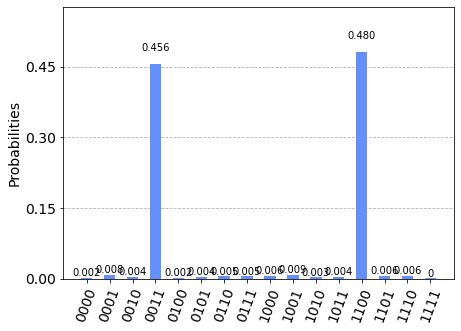

In [10]:
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

## Conclusion
While our hash function was very simple and not a very strong one, the result of this experiment shows that we can use quantum computers to search for collisions in $O(\sqrt{N})$ time. The current infrastructure we have for quantum computing is too slow and error-prone, unfortunately, in order to test this on a more modern hashing method. However, when that day comes, the current implementation of this can later be improved with a more standard hash function like *MD5* or *SHA-256* to find collisions for any given hash value.